In [1]:
!pip install torch==2.5.1+cu121 torchvision==0.20.1+cu121 torchaudio==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
!pip install ultralytics
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 34.9 MB/s eta 0:00:00
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
!pip install tensorflow tensorflow-datasets matplotlib opencv-python-headless

In [4]:
%pip install torch torchvision albumentations

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install opendatasets --upgrade

In [6]:
!pip install transformers torch datasets

In [7]:
import opendatasets as od
import cv2
import imghdr
import tensorflow as tf
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

In [8]:
#Load the data from kaggle
image_path = "https://www.kaggle.com/datasets/anasmohammedtahir/covidqu"

{"username":"ibebenedict","key":"f9402928d7dce1078c5310e48dfb2874"}

In [9]:
od.download(image_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ibebenedict


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu


100%|██████████| 1.15G/1.15G [00:36<00:00, 34.3MB/s]


Data 2

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="sQ7Zcf0WJbusFOZSjhEZ")
project = rf.workspace("tattoo-skin-disease").project("algaebloom-xstlo")
version = project.version(1)
dataset = version.download("voc")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AlgaeBloom-1 in voc:: 100%|██████████| 896/896 [00:00<00:00, 3697.93it/s]


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

# Function to create and save masks from Pascal VOC annotations with hierarchy support
def create_and_save_masks_from_voc_annotations(image_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    data = []

    for filename in os.listdir(image_dir):
        if not filename.endswith('.xml'):
            continue

        annotation_path = os.path.join(image_dir, filename)
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get the image file name
        img_filename = root.find('filename').text
        original_image_path = os.path.join(image_dir, img_filename)

        # Load the original image
        image = cv2.imread(original_image_path)
        if image is None:
            print(f"Error loading image: {original_image_path}")
            continue

        height, width = image.shape[:2]  # Image dimensions
        mask = np.zeros((height, width), dtype=np.uint8)  # Initialize a blank mask

        # Process each object in the annotation
        polygons = {'Water': [], 'AlgaeBloom': []}

        for obj in root.findall('object'):
            label = obj.find('name').text  # Retrieve class label
            polygon = obj.find('polygon')

            if polygon is not None:
                points = []
                for i in range(1, len(polygon) // 2 + 1):
                    try:
                        x = int(float(polygon.find(f'x{i}').text))
                        y = int(float(polygon.find(f'y{i}').text))
                        points.append((x, y))
                    except (ValueError, AttributeError) as e:
                        print(f"Error parsing polygon points in {filename}: {e}")
                        continue

                if len(points) < 3:
                    print(f"Skipping invalid polygon with insufficient points in {filename}")
                    continue

                polygons[label].append(np.array(points, dtype=np.int32))

        # Draw water polygons first (background)
        for water_polygon in polygons['Water']:
            cv2.fillPoly(mask, [water_polygon], 128)  # Water class value: 128

        # Draw algae bloom polygons on top (foreground)
        for algae_polygon in polygons['AlgaeBloom']:
            cv2.fillPoly(mask, [algae_polygon], 255)  # AlgaeBloom class value: 255

        # Save the mask image
        mask_filename = img_filename.replace('.jpg', '_mask.png').replace('.jpeg', '_mask.png').replace('.png', '_mask.png')
        mask_path = os.path.join(output_dir, mask_filename)
        cv2.imwrite(mask_path, mask)

        data.append({
            'Original_Image_Path': original_image_path,
            'Segmentation_Mask_Path': mask_path,
            'Label': 'Hierarchical'  # Hierarchical segmentation
        })

    return pd.DataFrame(data)

# Paths
base_dir = '/kaggle/working/AlgaeBloom-1'

# Define directories for train and test data
train_image_dir = os.path.join(base_dir, 'train')
test_image_dir = os.path.join(base_dir, 'test')

# Define directories for saving masks
train_output_dir = os.path.join(train_image_dir, 'masks')
test_output_dir = os.path.join(test_image_dir, 'masks')

# Create masks and DataFrame for training data
df_algae_bloom_train = create_and_save_masks_from_voc_annotations(
    train_image_dir,
    train_output_dir
)

# Create masks and DataFrame for test data
df_algae_bloom_test = create_and_save_masks_from_voc_annotations(
    test_image_dir,
    test_output_dir
)

# Combine train and test data
df_algae_bloom = pd.concat([df_algae_bloom_train, df_algae_bloom_test], ignore_index=True)

# Display the DataFrame
print(df_algae_bloom.head())

                                 Original_Image_Path  \
0  /kaggle/working/AlgaeBloom-1/train/-_-2-1-scre...   
1  /kaggle/working/AlgaeBloom-1/train/-_-TV-Yonha...   
2  /kaggle/working/AlgaeBloom-1/train/google_0022...   
3  /kaggle/working/AlgaeBloom-1/train/google_0010...   
4  /kaggle/working/AlgaeBloom-1/train/google_0365...   

                              Segmentation_Mask_Path         Label  
0  /kaggle/working/AlgaeBloom-1/train/masks/-_-2-...  Hierarchical  
1  /kaggle/working/AlgaeBloom-1/train/masks/-_-TV...  Hierarchical  
2  /kaggle/working/AlgaeBloom-1/train/masks/googl...  Hierarchical  
3  /kaggle/working/AlgaeBloom-1/train/masks/googl...  Hierarchical  
4  /kaggle/working/AlgaeBloom-1/train/masks/googl...  Hierarchical  


Data 3

In [17]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="sQ7Zcf0WJbusFOZSjhEZ")
project = rf.workspace("breast-cancer-vzarh").project("cancer-detection-uozuy")
version = project.version(3)
dataset = version.download("voc")
                

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cancer-Detection-3 in voc:: 100%|██████████| 12059/12059 [00:01<00:00, 7275.06it/s]


In [18]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import pandas as pd

# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128

In [19]:
# Function to create and save masks from Pascal VOC annotations
def create_and_save_masks_from_voc_annotations(image_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    data = []
    
    for filename in os.listdir(image_dir):
        if not filename.endswith('.xml'):
            continue
            
        annotation_path = os.path.join(image_dir, filename)
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        # Get the image file name
        img_filename = root.find('filename').text
        original_image_path = os.path.join(image_dir, img_filename)
        
        # Load the original image
        image = cv2.imread(original_image_path)
        if image is None:
            print(f"Error loading image: {original_image_path}")
            continue
        
        # Create a blank mask
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # Draw the bounding boxes on the mask
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), 255, -1)
        
        # Save the mask image
        mask_filename = img_filename.replace('.jpg', '_mask.png').replace('.jpeg', '_mask.png').replace('.png', '_mask.png')
        mask_path = os.path.join(output_dir, mask_filename)
        cv2.imwrite(mask_path, mask)
        
        data.append({
            'Original_Image_Path': original_image_path,
            'Segmentation_Mask_Path': mask_path,
            'Label': 'Breast Cancer'
        })
    
    return pd.DataFrame(data)

In [20]:
# Paths
base_dir = '/kaggle/working/Cancer-Detection-3'

# Define directories for train, validation, and test data
train_image_dir = os.path.join(base_dir, 'train')
valid_image_dir = os.path.join(base_dir, 'valid')
test_image_dir = os.path.join(base_dir, 'test')

# Define directories for saving masks
train_output_dir = os.path.join(train_image_dir, 'masks')
valid_output_dir = os.path.join(valid_image_dir, 'masks')
test_output_dir = os.path.join(test_image_dir, 'masks')

# Create masks and DataFrame for training data
df_breast_cancer_train = create_and_save_masks_from_voc_annotations(
    train_image_dir,
    train_output_dir
)

# Create masks and DataFrame for validation data
df_breast_cancer_valid = create_and_save_masks_from_voc_annotations(
    valid_image_dir,
    valid_output_dir
)

# Create masks and DataFrame for test data
df_breast_cancer_test = create_and_save_masks_from_voc_annotations(
    test_image_dir,
    test_output_dir
)

# Combine train, validation, and test data
df_breast_cancer = pd.concat([df_breast_cancer_train, df_breast_cancer_valid, df_breast_cancer_test], ignore_index=True)

# Display the DataFrame
df_breast_cancer.head()

Original_Image_Path  \
0  /kaggle/working/Cancer-Detection-3/train/mdb08...   
1  /kaggle/working/Cancer-Detection-3/train/mdb03...   
2  /kaggle/working/Cancer-Detection-3/train/mdb19...   
3  /kaggle/working/Cancer-Detection-3/train/mdb05...   
4  /kaggle/working/Cancer-Detection-3/train/mdb23...   

                              Segmentation_Mask_Path          Label  
0  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
1  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
2  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
3  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
4  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer

In [21]:
df_breast_cancer

Original_Image_Path  \
0     /kaggle/working/Cancer-Detection-3/train/mdb08...   
1     /kaggle/working/Cancer-Detection-3/train/mdb03...   
2     /kaggle/working/Cancer-Detection-3/train/mdb19...   
3     /kaggle/working/Cancer-Detection-3/train/mdb05...   
4     /kaggle/working/Cancer-Detection-3/train/mdb23...   
...                                                 ...   
6022  /kaggle/working/Cancer-Detection-3/test/mdb222...   
6023  /kaggle/working/Cancer-Detection-3/test/mdb080...   
6024  /kaggle/working/Cancer-Detection-3/test/mdb125...   
6025  /kaggle/working/Cancer-Detection-3/test/mdb171...   
6026  /kaggle/working/Cancer-Detection-3/test/mdb013...   

                                 Segmentation_Mask_Path          Label  
0     /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
1     /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
2     /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
3     /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
4     /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
...                                                 ...            ...  
6022  /kaggle/working/Cancer-Detection-3/test/masks/...  Breast Cancer  
6023  /kaggle/working/Cancer-Detection-3/test/masks/...  Breast Cancer  
6024  /kaggle/working/Cancer-Detection-3/test/masks/...  Breast Cancer  
6025  /kaggle/working/Cancer-Detection-3/test/masks/...  Breast Cancer  
6026  /kaggle/working/Cancer-Detection-3/test/masks/...  Breast Cancer  

[6027 rows x 3 columns]

New data breast cancer

combined

In [22]:
# Ensure df_all and df_covid have been created as per your previous steps

# Combine the DataFrames
df_combined = pd.concat([df_breast_cancer, df_covid_images, df_brain_tumor], ignore_index=True)

# Display the combined DataFrame
df_combined.head()

Original_Image_Path  \
0  /kaggle/working/Cancer-Detection-3/train/mdb08...   
1  /kaggle/working/Cancer-Detection-3/train/mdb03...   
2  /kaggle/working/Cancer-Detection-3/train/mdb19...   
3  /kaggle/working/Cancer-Detection-3/train/mdb05...   
4  /kaggle/working/Cancer-Detection-3/train/mdb23...   

                              Segmentation_Mask_Path          Label  
0  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
1  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
2  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
3  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
4  /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer

In [23]:
df_combined

Original_Image_Path  \
0      /kaggle/working/Cancer-Detection-3/train/mdb08...   
1      /kaggle/working/Cancer-Detection-3/train/mdb03...   
2      /kaggle/working/Cancer-Detection-3/train/mdb19...   
3      /kaggle/working/Cancer-Detection-3/train/mdb05...   
4      /kaggle/working/Cancer-Detection-3/train/mdb23...   
...                                                  ...   
12729  /kaggle/working/Brain_tumer-1/test/y51_jpg.rf....   
12730  /kaggle/working/Brain_tumer-1/test/y494_jpg.rf...   
12731  /kaggle/working/Brain_tumer-1/test/y79_jpg.rf....   
12732  /kaggle/working/Brain_tumer-1/test/y88_jpg.rf....   
12733  /kaggle/working/Brain_tumer-1/test/y98_jpg.rf....   

                                  Segmentation_Mask_Path          Label  
0      /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
1      /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
2      /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
3      /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
4      /kaggle/working/Cancer-Detection-3/train/masks...  Breast Cancer  
...                                                  ...            ...  
12729  /kaggle/working/Brain_tumer-1/test/masks/y51_j...          Tumor  
12730  /kaggle/working/Brain_tumer-1/test/masks/y494_...          Tumor  
12731  /kaggle/working/Brain_tumer-1/test/masks/y79_j...          Tumor  
12732  /kaggle/working/Brain_tumer-1/test/masks/y88_j...          Tumor  
12733                                               None       No Tumor  

[12734 rows x 3 columns]

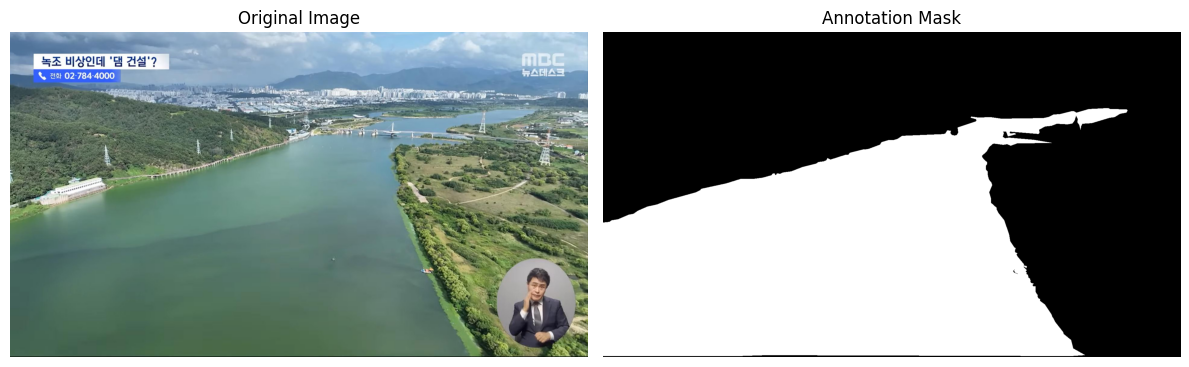

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET

# Load the image
image_path = '/kaggle/working/AlgaeBloom-1/train/-2024-08-23_-_MBC-1-56-screenshot_png.rf.41cf55d0b831cf839cd9915971c39d88.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Parse the XML annotation
xml_path = '/kaggle/working/AlgaeBloom-1/train/-2024-08-23_-_MBC-1-56-screenshot_png.rf.41cf55d0b831cf839cd9915971c39d88.xml'
tree = ET.parse(xml_path)
root = tree.getroot()

# Create a blank mask for visualization
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Extract polygon points from the XML
for obj in root.findall('object'):
    label = obj.find('name').text
    polygon = obj.find('polygon')

    if polygon is not None:
        points = []
        for i in range(1, len(polygon) // 2 + 1):
            x = int(float(polygon.find(f'x{i}').text))
            y = int(float(polygon.find(f'y{i}').text))
            points.append((x, y))

        points = np.array(points, dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)  # Fill the polygon on the mask

# Display the original image and the mask side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Annotation Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()


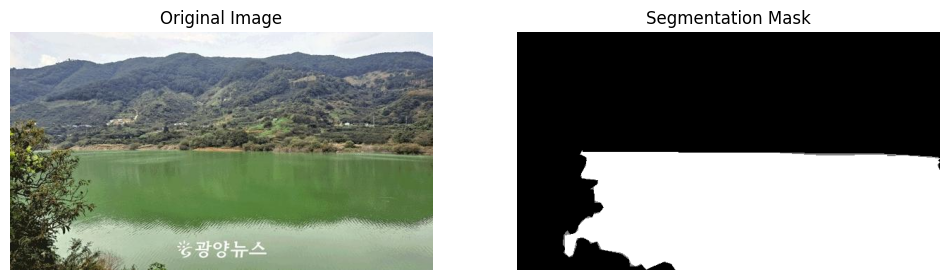

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Assuming df_combined is already defined and contains the dataset information
# df_combined = pd.read_csv('path_to_your_csv_file.csv')


# Select an index to view (e.g., the first one)
index = 0

# Get the paths for the original image and its corresponding segmentation mask
original_image_path = df_algae_bloom.iloc[index]['Original_Image_Path']
segmentation_mask_path = df_algae_bloom.iloc[index]['Segmentation_Mask_Path']

# Load the images
original_image = Image.open(original_image_path).convert("RGB")
segmentation_mask = Image.open(segmentation_mask_path).convert("L")

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(segmentation_mask, cmap='gray')
axes[1].set_title('Segmentation Mask')
axes[1].axis('off')

plt.show()

Original Image Path: /kaggle/working/AlgaeBloom-1/train/vlcsnap-2024-09-24-14h17m05s933_png.rf.47c0944fc447f36e7f4b3bfcfb7ff5da.jpg
Mask Path: /kaggle/working/AlgaeBloom-1/train/masks/vlcsnap-2024-09-24-14h17m05s933_png.rf.47c0944fc447f36e7f4b3bfcfb7ff5da_mask_mask.png
Label: Hierarchical
Original Image Shape: (1080, 1920, 3)
Mask Shape: (1080, 1920)


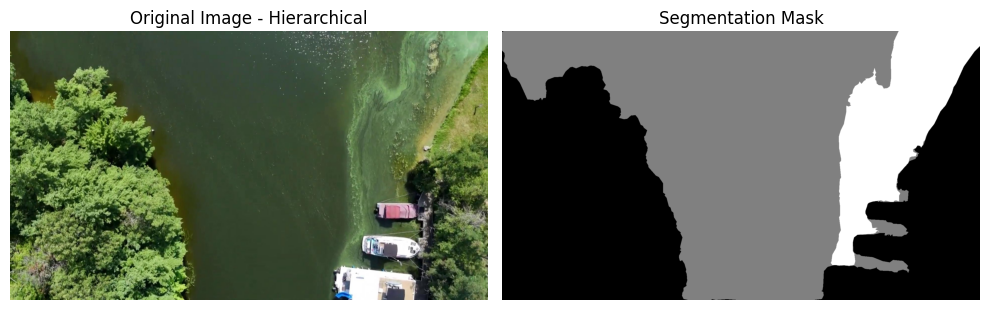

In [6]:
import matplotlib.pyplot as plt
import cv2

# Function to display an original image and its mask
def display_image_and_mask(df, index):
    # Get the file paths for the original image and mask
    original_image_path = df.loc[index, 'Original_Image_Path']
    mask_path = df.loc[index, 'Segmentation_Mask_Path']
    label = df.loc[index, 'Label']
    
    print(f"Original Image Path: {original_image_path}")
    print(f"Mask Path: {mask_path}")
    print(f"Label: {label}")
    
    # Load the original image and mask
    original_image = cv2.imread(original_image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if original_image is None:
        print(f"Error loading original image from {original_image_path}")
        return
    if mask is None:
        print(f"Error loading mask from {mask_path}")
        return
    
    print(f"Original Image Shape: {original_image.shape}")
    print(f"Mask Shape: {mask.shape}")
    
    # Convert original image to RGB
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Plot the original image and mask side by side
    plt.figure(figsize=(10, 5))
    
    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f'Original Image - {label}')
    plt.axis('off')
    
    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Example usage
# Assuming `df_algae_bloom` is your DataFrame
display_image_and_mask(df_algae_bloom, index=4)


In [7]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Function to load and preprocess images and masks
def load_image(image_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    image = cv2.resize(image, (img_height, img_width))  # Resize image
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image / 255.0  # Normalize the pixel values

def load_data(df):
    images = []
    masks = []
    
    for index, row in df.iterrows():
        # Load original image
        original_image = load_image(row['Original_Image_Path'])
        
        # Handle missing infection masks (Non-COVID and Normal classes)
        if pd.isna(row['Segmentation_Mask_Path']):
            infection_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))  # Create an empty mask for Non-COVID/Normal
        else:
            infection_mask = load_image(row['Segmentation_Mask_Path'])
        
        # If either image or mask couldn't be loaded, skip this record
        if original_image is None or infection_mask is None:
            continue
        
        images.append(original_image)
        masks.append(infection_mask)
    
    return np.array(images), np.array(masks)

# Load the dataframe (df_covid_images) containing paths to images and masks
# Ensure df_covid_images is created as per the previous step

# Load the dataset (split into train and test sets)
X, y = load_data(df_algae_bloom)

# Check if data is loaded
if len(X) == 0 or len(y) == 0:
    raise ValueError("No images or masks loaded. Please check your data.")

# Split the dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

# Define the U-Net model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = Input(input_size)

    # Encoding path (downsampling)
    c1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(c4)

    # Decoding path (upsampling)
    u1 = Conv2DTranspose(256, kernel_size=3, strides=(2, 2), padding='same')(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(u1)
    c5 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c5)

    u2 = Conv2DTranspose(128, kernel_size=3, strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(u2)
    c6 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u3)
    c7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c7)

    # Output layer (single channel for binary classification)
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compile the model
unetmodel = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1))
unetmodel.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
unetmodel.summary()

# Train the U-Net model
history = unetmodel.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

# After training, the model can be saved and further evaluated if needed.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │      1,179,904 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 128)    │        295,040 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 8,556,353 (32.64 MB)

 Trainable params: 8,556,353 (32.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4817 - loss: 0.6559 - val_accuracy: 0.5566 - val_loss: 0.5682
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.5137 - loss: 0.5854 - val_accuracy: 0.5566 - val_loss: 0.6470
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.5079 - loss: 0.6277 - val_accuracy: 0.5566 - val_loss: 0.5296
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.5356 - loss: 0.5663 - val_accuracy: 0.6335 - val_loss: 0.5304
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5938 - loss: 0.5409 - val_accuracy: 0.6455 - val_loss: 0.4960
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5975 - loss: 0.5418 - val_accuracy: 0.6339 - val_loss: 0.4999
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.5945 - loss: 0.5375 - val_accuracy: 0.6467 - val_loss: 0.4960
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6241 - loss: 0.5095 - val_accuracy: 0.64

REAL SAM2

In [8]:
# Save the trained model
unetmodel.save('Ben_Algae_unet_segmentation_model.h5')

# Model evaluation on validation set
loss, accuracy = unetmodel.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Predict on new images (for future X-ray images)
def predict_segmentation(image_path):
    # Preprocess the image
    original_image = load_image(image_path)
    original_image = np.expand_dims(original_image, axis=0)  # Add batch dimension
    
    # Predict infection mask
    predicted_mask = unetmodel.predict(original_image)
    
    # Reshape back to original size and threshold to binary mask
    predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask
    
    return predicted_mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6729 - loss: 0.4279
Validation Loss: 0.4279366731643677
Validation Accuracy: 0.67286217212677


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Threshold the ground truth masks (y_val) to binary (0 or 1)
y_val_binary = (y_val > 0.5).astype(np.uint8)

# Predict on the validation set
y_pred = unetmodel.predict(X_val)

# Convert predictions to binary (threshold at 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Flatten the ground truth and predictions to calculate metrics
y_val_flat = y_val_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_val_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_val_flat, y_pred_flat)
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(y_val_flat, y_pred_flat)
print(f"Recall: {recall}")

# Calculate F1-Score
f1 = f1_score(y_val_flat, y_pred_flat)
print(f"F1-Score: {f1}")

# Calculate IoU (Intersection over Union)
intersection = np.logical_and(y_val_flat, y_pred_flat)
union = np.logical_or(y_val_flat, y_pred_flat)
iou = np.sum(intersection) / np.sum(union)
print(f"IoU: {iou}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Accuracy: 0.8874007515285326
Precision: 0.8523043736303871
Recall: 0.9002417104176588
F1-Score: 0.8756174278067498
IoU: 0.7787540019397023


In [10]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Function to calculate Average Precision (AP) for each image
def compute_average_precision(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true.flatten(), y_pred.flatten())
    return auc(recall, precision)  # Calculate the area under the precision-recall curve (AP)

# Function to compute mAP for the entire validation set
def compute_mAP(y_true, y_pred):
    ap_scores = []
    
    for i in range(len(y_true)):
        ap = compute_average_precision(y_true[i], y_pred[i])
        ap_scores.append(ap)
    
    mAP = np.mean(ap_scores)  # Mean of all the AP scores
    return mAP

# Threshold the ground truth masks (y_val) to binary (0 or 1)
y_val_binary = (y_val > 0.5).astype(np.uint8)

# Predict on the validation set
y_pred = unetmodel.predict(X_val)

# Convert predictions to binary (threshold at 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Compute the mAP for the U-Net model
mAP = compute_mAP(y_val_binary, y_pred_binary)
print(f"Mean Average Precision (mAP): {mAP}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Average Precision (mAP): 0.8856853145954698


No positive class found in y_true, recall is set to one for all thresholds.


In [47]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Function to calculate Average Precision (AP) for each image
def compute_average_precision(y_true, y_pred):
    # Only compute AP if the ground truth has positive pixels
    if np.sum(y_true) == 0:
        return None  # Skip cases with no positive pixels in the ground truth
    precision, recall, _ = precision_recall_curve(y_true.flatten(), y_pred.flatten())
    return auc(recall, precision)  # Calculate the area under the precision-recall curve (AP)

# Function to compute mAP for the entire validation set
def compute_mAP(y_true, y_pred):
    ap_scores = []
    
    for i in range(len(y_true)):
        ap = compute_average_precision(y_true[i], y_pred[i])
        if ap is not None:  # Only include non-None AP scores
            ap_scores.append(ap)
    
    if len(ap_scores) == 0:
        return 0.0  # If no valid AP scores were computed, return 0 mAP
    mAP = np.mean(ap_scores)  # Mean of all the AP scores
    return mAP

# Threshold the ground truth masks (y_val) to binary (0 or 1)
y_val_binary = (y_val > 0.5).astype(np.uint8)

# Predict on the validation set
y_pred = unetmodel.predict(X_val)

# Convert predictions to binary (threshold at 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Compute the mAP for the U-Net model
mAP = compute_mAP(y_val_binary, y_pred_binary)
print(f"Mean Average Precision (mAP): {mAP}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Mean Average Precision (mAP): 0.8724408774191406


In [11]:
unetmodel.save('algae_unet_segmentation_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


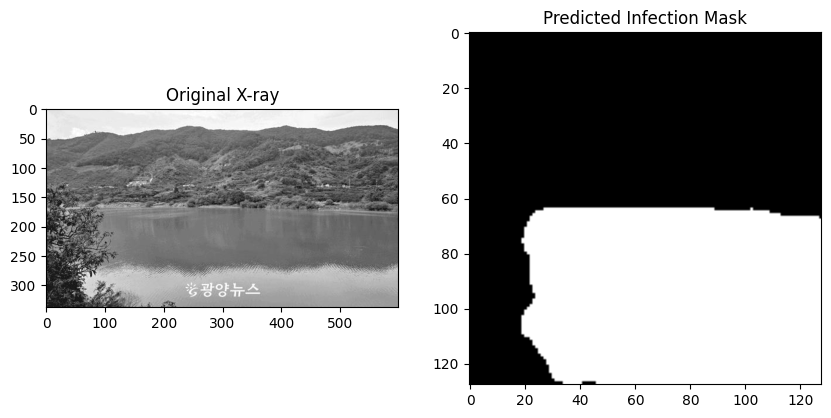

In [12]:
# Test prediction on a new X-ray image
test_image_path = df_algae_bloom.iloc[0]['Original_Image_Path']  # Example test
predicted_mask = predict_segmentation(test_image_path)

# Show original and predicted mask
import matplotlib.pyplot as plt

# Load the original image
original_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original X-ray')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Predicted Infection Mask')
plt.imshow(predicted_mask, cmap='gray')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


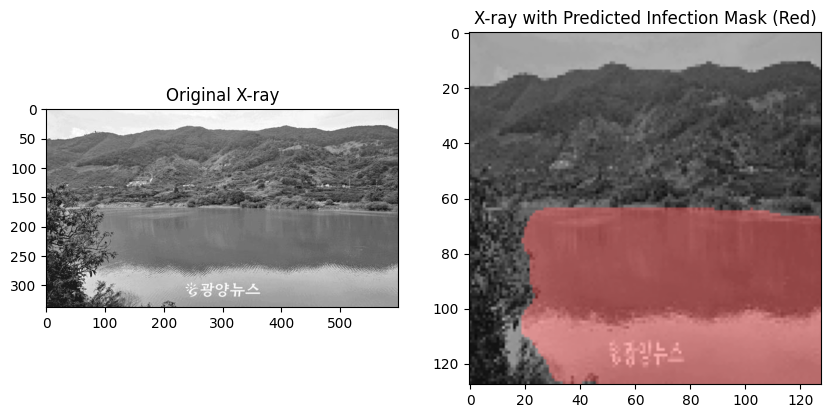

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to superimpose the infection mask on the original X-ray image
def superimpose_mask_on_xray(original_image, predicted_mask):
    # Ensure the original image and mask are the same size
    original_image_resized = cv2.resize(original_image, (predicted_mask.shape[1], predicted_mask.shape[0]))
    
    # Convert the original grayscale X-ray to RGB for overlaying
    original_image_rgb = cv2.cvtColor(original_image_resized, cv2.COLOR_GRAY2RGB)
    
    # Create a 3-channel (RGB) version of the predicted mask with red color for infected areas
    mask_rgb = np.zeros_like(original_image_rgb)
    mask_rgb[:, :, 0] = predicted_mask * 255  # Red channel, apply mask to highlight red
    
    # Superimpose the mask on the original image
    superimposed_image = cv2.addWeighted(original_image_rgb, 0.7, mask_rgb, 0.3, 0)
    
    return superimposed_image

# Load the original image (grayscale) and predicted mask
test_image_path = df_algae_bloom.iloc[0]['Original_Image_Path']  # Example test
original_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Predict the mask for the test image
predicted_mask = predict_segmentation(test_image_path)

# Superimpose the predicted mask on the original X-ray
superimposed_image = superimpose_mask_on_xray(original_image, predicted_mask)

# Show the original X-ray and the superimposed image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original X-ray')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('X-ray with Predicted Infection Mask (Red)')
plt.imshow(superimposed_image)

plt.show()

CLIP MODEL

end

SAM2

In [3]:
!git clone https://github.com/facebookresearch/sam2.git

%cd sam2

!pip install -e .

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 41.42 MiB/s, done.
Resolving deltas: 100% (376/376), done.
/kaggle/working/sam2
Obtaining file:///kaggle/working/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.2 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp310-cp310-linux_x86_64.whl size=13805 sha256=e46f7eadb6bab9d1e98e3ffba3fdec14b37a13112bdc5c776f07d50db010f10a
  Stored in directory: /tmp/pip-ephem-wheel-cache-pmeab8z0

In [4]:
!wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
!wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
!wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
!wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

--2025-01-23 20:05:03--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.81, 18.164.78.72, 18.164.78.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   146MB/s    in 1.0s    

2025-01-23 20:05:04 (146 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2025-01-23 20:05:05--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.128, 18.164.78.121, 18.164.78.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [application/

In [5]:
from sklearn.model_selection import train_test_split


# Split the dataset into 80% training and 20% temporary
train_df, temp_df = train_test_split(df_algae_bloom, test_size=0.2, random_state=42)

# Split the temporary set into 50% validation and 50% test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print the size of each set
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 356
Validation set size: 45
Test set size: 45


In [6]:
import numpy as np
import torch
import cv2
import os
import pandas as pd
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

def get_bbox_from_mask(mask):
    """Extract bounding box from binary mask"""
    y_indices, x_indices = np.nonzero(mask)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None
    x_min = np.min(x_indices)
    x_max = np.max(x_indices)
    y_min = np.min(y_indices)
    y_max = np.max(y_indices)
    return [x_min, y_min, x_max, y_max]

def read_batch(df_combined):
    """Read random image and its annotation from the dataset"""
    row = df_combined.iloc[np.random.randint(len(df_combined))]
    Img = cv2.imread(row['Original_Image_Path'])[..., ::-1]  # read image (BGR to RGB)
    ann_map = cv2.imread(row['Segmentation_Mask_Path'], 0)  # read mask in grayscale
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    inds = np.unique(ann_map)[1:]  
    boxes, masks = [], []
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)
        bbox = get_bbox_from_mask(mask)
        if bbox is not None:
            masks.append(mask)
            boxes.append(bbox)
    if len(masks) == 0:
        return None, None, None
    return Img, np.array(masks), np.array(boxes)

def train_sam2(df_combined, num_iterations=1000, save_interval=100):
    """Train SAM2 model and compute mean IoU"""
    sam2_checkpoint = "/kaggle/working/sam2/sam2_hiera_large.pt"
    model_cfg = "sam2_hiera_l.yaml"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
    predictor = SAM2ImagePredictor(sam2_model)
    predictor.model.sam_mask_decoder.train(True)
    predictor.model.sam_prompt_encoder.train(True)
    optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=1e-5, weight_decay=4e-5)
    scaler = torch.cuda.amp.GradScaler()

    total_iou = 0
    num_samples = 0

    for itr in range(num_iterations):
        with torch.cuda.amp.autocast():
            image, mask, boxes = read_batch(df_combined)
            if mask is None or mask.shape[0] == 0:
                continue
            predictor.set_image(image)
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                point_coords=None, point_labels=None, box=boxes, mask_logits=None, normalize_coords=True)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=None, boxes=unnorm_box, masks=None)
            batched_mode = boxes.shape[0] > 1
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
            gt_mask = torch.tensor(mask.astype(np.float32)).to(device)
            prd_mask = torch.sigmoid(prd_masks[:, 0])
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()
            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            union = (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            iou = inter / (union + 1e-6)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss + score_loss * 0.05
            predictor.model.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Update IoU metrics
            total_iou += iou.sum().item()
            num_samples += iou.shape[0]

            if itr % save_interval == 0:
                torch.save(predictor.model.state_dict(), f"sam2_checkpoint_{itr}.pth")

            mean_iou = total_iou / max(num_samples, 1)  # Avoid division by zero
            print(f"Step {itr}, Loss: {loss.item():.4f}, Mean IoU: {mean_iou:.4f}")

    final_mean_iou = total_iou / max(num_samples, 1)
    print(f"Final Mean IoU: {final_mean_iou:.4f}")
    torch.save(predictor.model.state_dict(), f"/kaggle/working/sam2_medseg_model.pth")
    return predictor, final_mean_iou

# Example usage
if __name__ == "__main__":
    trained_model, final_mean_iou = train_sam2(train_df, num_iterations=3000, save_interval=1500)
    print(f"Final Mean IoU after training: {final_mean_iou:.4f}")

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Step 0, Loss: 0.0946, Mean IoU: 0.6028
Step 1, Loss: 0.0257, Mean IoU: 0.7262
Step 2, Loss: 0.1129, Mean IoU: 0.7760
Step 3, Loss: 0.5810, Mean IoU: 0.6673
Step 4, Loss: 0.6616, Mean IoU: 0.6189
Step 5, Loss: 0.2483, Mean IoU: 0.5595
Step 6, Loss: 0.0169, Mean IoU: 0.6202
Step 7, Loss: 0.1992, Mean IoU: 0.6353
Step 8, Loss: 0.7697, Mean IoU: 0.6174
Step 9, Loss: 0.1099, Mean IoU: 0.6098
Step 10, Loss: 0.3847, Mean IoU: 0.5972
Step 11, Loss: 0.4175, Mean IoU: 0.5759
Step 12, Loss: 0.1078, Mean IoU: 0.5900
Step 13, Loss: 0.0548, Mean IoU: 0.6011
Step 14, Loss: 0.2225, Mean IoU: 0.6110
Step 15, Loss: 0.0504, Mean IoU: 0.6114
Step 16, Loss: 0.5830, Mean IoU: 0.6023
Step 17, Loss: 0.0583, Mean IoU: 0.6130
Step 18, Loss: 0.0602, Mean IoU: 0.6237
Step 19, Loss: 0.1945, Mean IoU: 0.6369
Step 20, Loss: 0.1432, Mean IoU: 0.6442
Step 21, Loss: 0.1102, Mean IoU: 0.6361
Step 22, Loss: 0.1735, Mean IoU: 0.6359
Step 23, Loss: 0.1109, Mean IoU: 0.6435
Step 24, Loss: 0.6638, Mean IoU: 0.6391
Step 25, L

In [7]:
import torch

# Path to the existing checkpoint
old_checkpoint_path = "/kaggle/working/sam2_medseg_model.pth"
new_checkpoint_path = "/kaggle/working/sam2_final_model_resaved.pth"

# Load the existing checkpoint
checkpoint = torch.load(old_checkpoint_path, map_location="cpu")

# Check if the checkpoint is already in the correct format
if "model" not in checkpoint:
    # Assuming the checkpoint contains the model's state_dict directly
    new_checkpoint = {"model": checkpoint}
else:
    new_checkpoint = checkpoint  # Already in correct format

# Save the new checkpoint
torch.save(new_checkpoint, new_checkpoint_path)

print(f"Model checkpoint re-saved at: {new_checkpoint_path}")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Model checkpoint re-saved at: /kaggle/working/sam2_final_model_resaved.pth


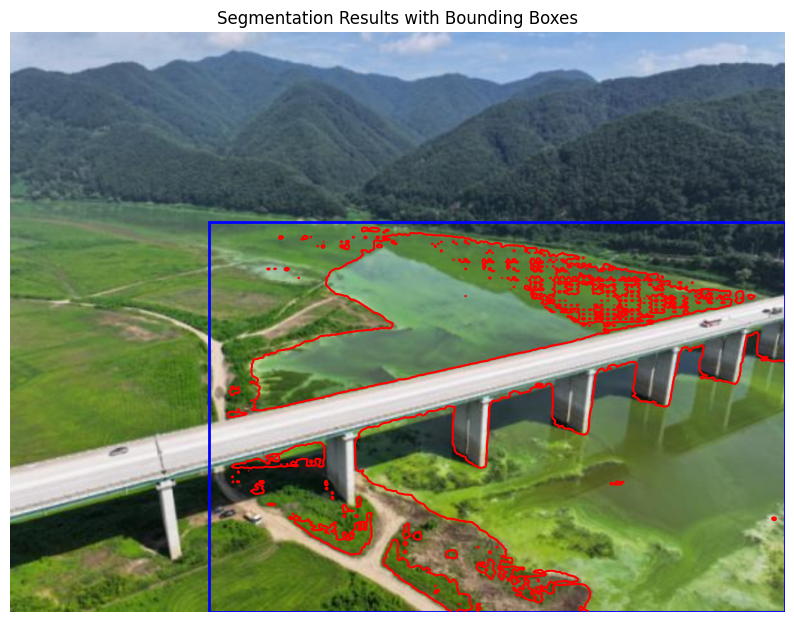

TypeError: cannot unpack non-iterable NoneType object

In [8]:
import numpy as np
import cv2
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import matplotlib.pyplot as plt

def get_bbox_from_mask(mask):
    """Extract bounding box from binary mask."""
    y_indices, x_indices = np.nonzero(mask)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None
    x_min = np.min(x_indices)
    x_max = np.max(x_indices)
    y_min = np.min(y_indices)
    y_max = np.max(y_indices)
    return [x_min, y_min, x_max, y_max]

def predict_with_bboxes(test_df, model_checkpoint, model_cfg, device="cuda"):
    """Perform segmentation using bounding boxes from a ground-truth mask."""
    # Load trained model
    sam2_model = build_sam2(model_cfg, model_checkpoint, device=device)
    predictor = SAM2ImagePredictor(sam2_model)

    # Take one image and its mask from test_df
    row = test_df.iloc[0]  # Use the first row for demonstration
    image_path = row['Original_Image_Path']
    mask_path = row['Segmentation_Mask_Path']

    # Load image and ground-truth mask
    image = cv2.imread(image_path)[..., ::-1]  # BGR to RGB
    mask = cv2.imread(mask_path, 0)  # Grayscale mask

    # Resize image and mask
    r = np.min([1024 / image.shape[1], 1024 / image.shape[0]])
    image = cv2.resize(image, (int(image.shape[1] * r), int(image.shape[0] * r)))
    mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Get bounding boxes from ground-truth mask
    inds = np.unique(mask)[1:]  # Skip background
    boxes = []
    for ind in inds:
        instance_mask = (mask == ind).astype(np.uint8)
        bbox = get_bbox_from_mask(instance_mask)
        if bbox is not None:
            boxes.append(bbox)

    if not boxes:
        print("No valid bounding boxes found in mask.")
        return None

    boxes = np.array(boxes)

    # Perform segmentation using bounding boxes
    predictor.set_image(image)

    # Prepare bounding boxes as prompts
    _, _, _, unnorm_box = predictor._prep_prompts(
        point_coords=None,
        point_labels=None,
        box=boxes,
        mask_logits=None,
        normalize_coords=True,
    )

    sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
        points=None,
        boxes=unnorm_box,
        masks=None,
    )

    # Decode masks
    batched_mode = boxes.shape[0] > 1  # Determine batched mode
    high_res_features = [feat[-1].unsqueeze(0) for feat in predictor._features["high_res_feats"]]
    low_res_masks, scores, _, _ = predictor.model.sam_mask_decoder(
        image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
        image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
        repeat_image=batched_mode,
        high_res_features=high_res_features,  # Pass extracted features
    )

    # Post-process masks
    masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

    # Visualize results
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    # Detach masks and loop through each 2D slice for visualization
    for i, mask in enumerate(masks.detach().cpu().numpy()):
        plt.contour(mask.squeeze(), colors='red', levels=[0.5])  # Contour of the predicted mask
    
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='blue', facecolor='none', lw=2))  # Bounding box
    
    plt.axis('off')
    plt.title("Segmentation Results with Bounding Boxes")
    plt.show()


# Example usage
if __name__ == "__main__":
    model_checkpoint = "/kaggle/working/sam2_final_model_resaved.pth"
    model_cfg = "sam2_hiera_l.yaml"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    masks, boxes = predict_with_bboxes(test_df, model_checkpoint, model_cfg, device=device)

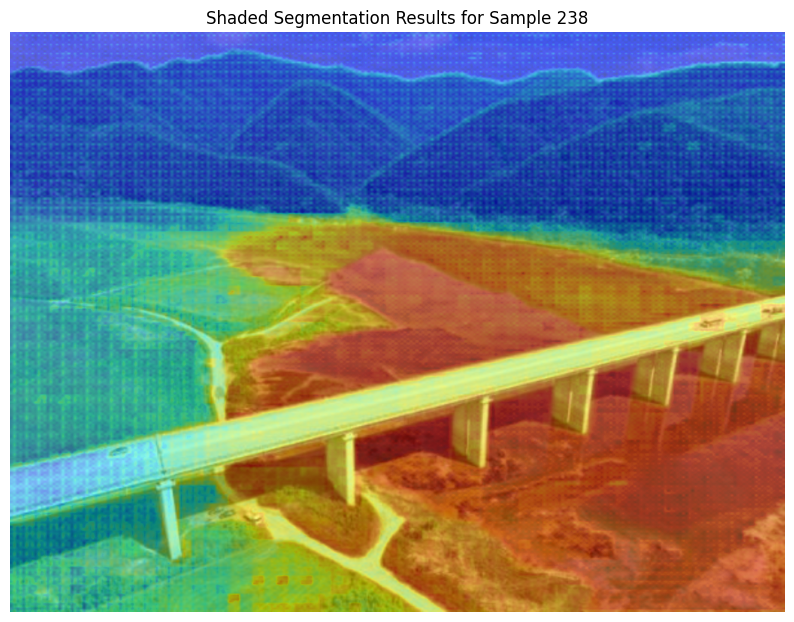

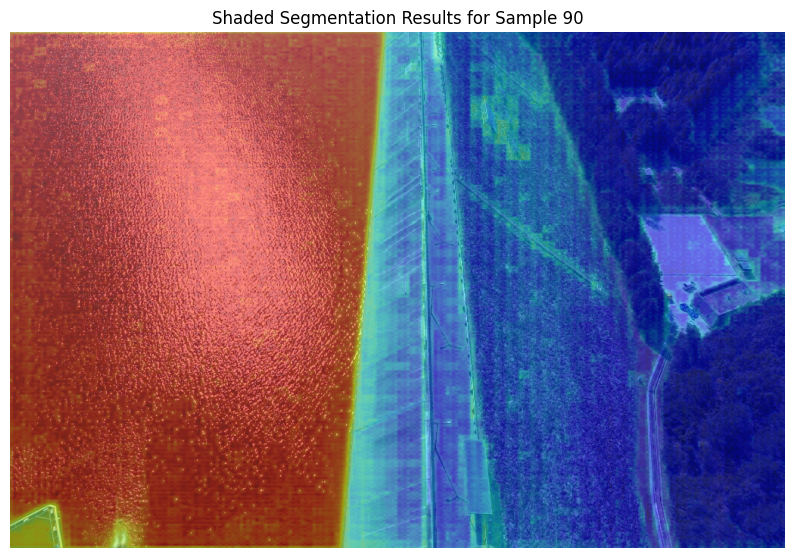

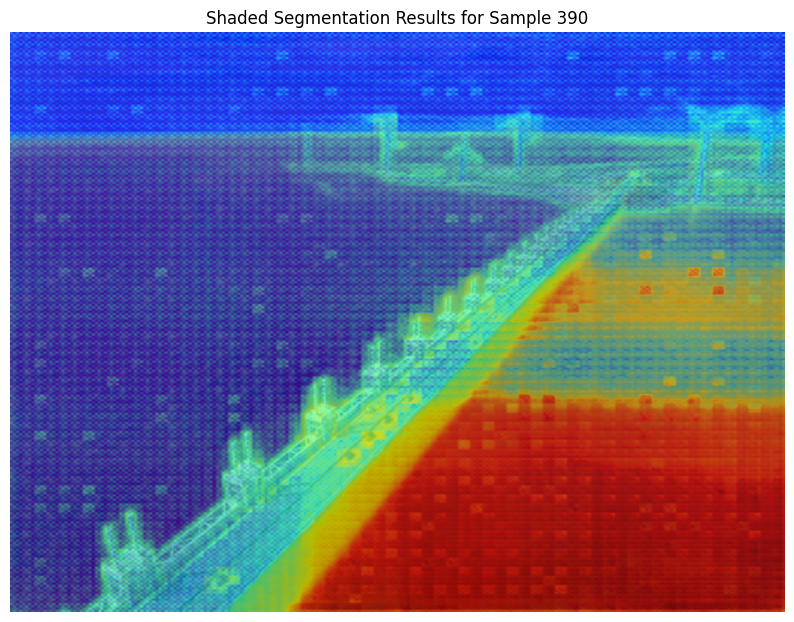

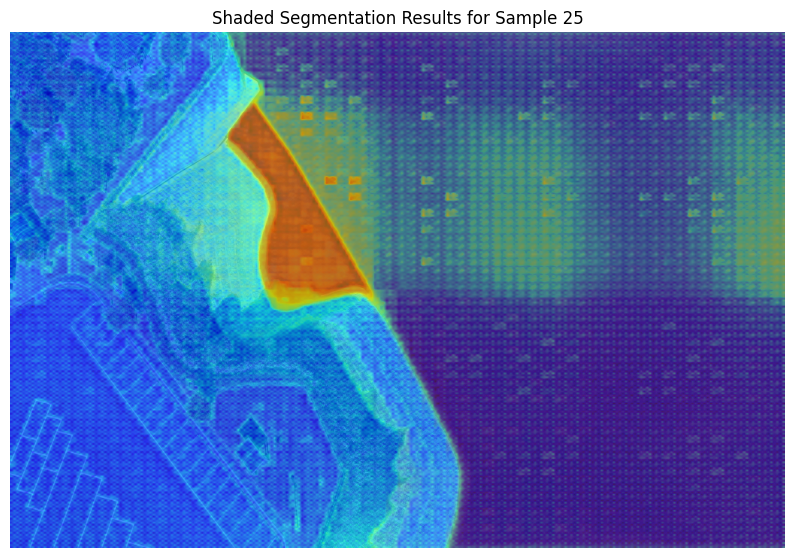

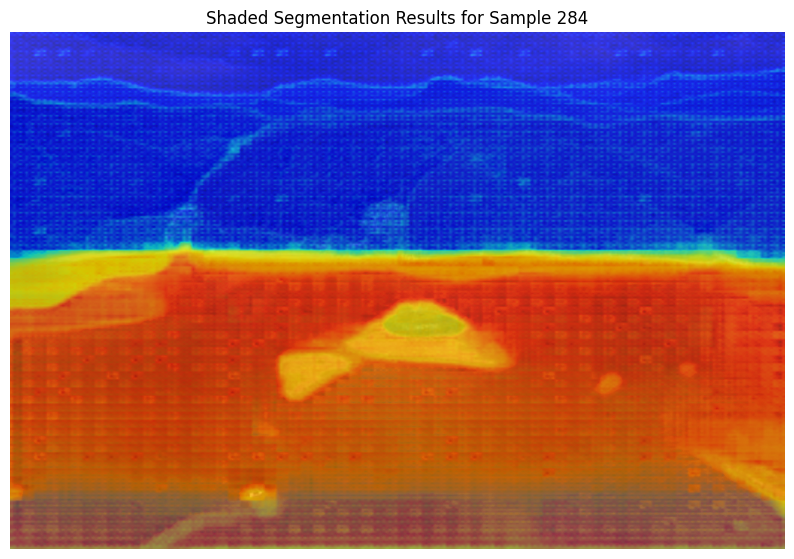

No valid bounding boxes found for sample 297.
Mean Dice Score: 0.9244
Final Mean Dice Score: 0.9244


In [10]:
import numpy as np
import cv2
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import matplotlib.pyplot as plt

def get_bbox_from_mask(mask):
    """Extract bounding box from binary mask."""
    y_indices, x_indices = np.nonzero(mask)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None
    x_min = np.min(x_indices)
    x_max = np.max(x_indices)
    y_min = np.min(y_indices)
    y_max = np.max(y_indices)
    return [x_min, y_min, x_max, y_max]

def calculate_dice_score(predicted_masks, ground_truth_masks):
    """
    Compute the Dice score for predicted and ground truth masks.

    Parameters:
    - predicted_masks: A torch tensor of shape (N, H, W), where N is the number of masks.
    - ground_truth_masks: A torch tensor of shape (N, H, W), where N is the number of masks.

    Returns:
    - dice_scores: A list of Dice scores for each mask pair.
    """
    dice_scores = []
    for prd_mask, gt_mask in zip(predicted_masks, ground_truth_masks):
        prd_mask = (prd_mask > 0.5).float()  # Binarize predicted mask
        gt_mask = (gt_mask > 0).float()  # Ensure ground-truth mask is binary
        intersection = (prd_mask * gt_mask).sum()
        union = prd_mask.sum() + gt_mask.sum()
        dice = (2 * intersection) / (union + 1e-6)  # Add epsilon to avoid division by zero
        dice_scores.append(dice.item())
    return dice_scores

def predict_with_shaded_masks(test_df, model_checkpoint, model_cfg, device="cuda", max_visualizations=5):
    """Perform segmentation and calculate Dice score with shaded visualizations."""
    sam2_model = build_sam2(model_cfg, model_checkpoint, device=device)
    predictor = SAM2ImagePredictor(sam2_model)

    dice_scores = []  # List to store Dice scores
    visualization_count = 0

    for idx, row in test_df.iterrows():
        image_path = row['Original_Image_Path']
        mask_path = row['Segmentation_Mask_Path']

        # Load and preprocess image and mask
        image = cv2.imread(image_path)[..., ::-1]  # BGR to RGB
        gt_mask = cv2.imread(mask_path, 0)  # Grayscale mask
        r = np.min([1024 / image.shape[1], 1024 / image.shape[0]])
        image = cv2.resize(image, (int(image.shape[1] * r), int(image.shape[0] * r)))
        gt_mask = cv2.resize(gt_mask, (int(gt_mask.shape[1] * r), int(gt_mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

        # Get bounding boxes from ground-truth mask
        inds = np.unique(gt_mask)[1:]  # Skip background
        boxes = []
        for ind in inds:
            instance_mask = (gt_mask == ind).astype(np.uint8)
            bbox = get_bbox_from_mask(instance_mask)
            if bbox is not None:
                boxes.append(bbox)

        if not boxes:
            print(f"No valid bounding boxes found for sample {idx}.")
            continue

        boxes = np.array(boxes)

        # Perform segmentation
        predictor.set_image(image)
        _, _, _, unnorm_box = predictor._prep_prompts(
            point_coords=None,
            point_labels=None,
            box=boxes,
            mask_logits=None,
            normalize_coords=True,
        )

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=None,
            boxes=unnorm_box,
            masks=None,
        )

        batched_mode = boxes.shape[0] > 1
        high_res_features = [feat[-1].unsqueeze(0) for feat in predictor._features["high_res_feats"]]
        low_res_masks, _, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )

        # Post-process masks
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
        prd_masks = prd_masks.detach().cpu()
        gt_mask_tensor = torch.tensor((gt_mask > 0).astype(np.float32)).unsqueeze(0)  # Normalize ground-truth mask

        # Compute Dice scores
        sample_dice_scores = calculate_dice_score(prd_masks, gt_mask_tensor)
        dice_scores.extend(sample_dice_scores)

        # Visualize results (limit to max_visualizations)
        if visualization_count < max_visualizations:
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            for i, prd_mask in enumerate(prd_masks.numpy()):
                plt.imshow(prd_mask.squeeze(), alpha=0.5, cmap='jet')  # Overlay predicted mask with shading
            plt.axis('off')
            plt.title(f"Shaded Segmentation Results for Sample {idx}")
            plt.show()
            visualization_count += 1

    # Compute and print the mean Dice score
    mean_dice = np.mean(dice_scores)
    print(f"Mean Dice Score: {mean_dice:.4f}")
    return dice_scores, mean_dice

# Example usage
if __name__ == "__main__":
    model_checkpoint = "/kaggle/working/sam2_final_model_resaved.pth"
    model_cfg = "sam2_hiera_l.yaml"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    dice_scores, mean_dice = predict_with_shaded_masks(test_df, model_checkpoint, model_cfg, device=device, max_visualizations=5)
    print(f"Final Mean Dice Score: {mean_dice:.4f}")
